In [1]:
import cv2
import matplotlib.pyplot as plt
import pytesseract
import numpy as np

720 960 3


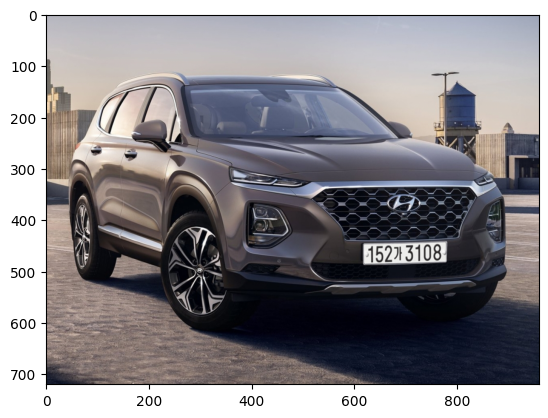

In [2]:
img_path = "./data/Car.png.png"
# img_gray = cv2.imread(img_path, 0)

# h, w= img_gray.shape
# print(h, w)
# plt.imshow(img_gray, 'gray')
# plt.show()


img_path = "./data/Car.png.png"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

h, w, c= img.shape
print(h, w, c)
plt.imshow(img)
plt.show()

Car image - Maximize contrast

In [3]:
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT,(9, 9))
print(structuringElement)

[[1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1]]


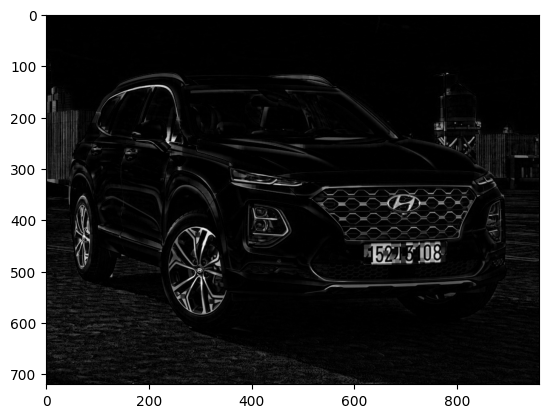

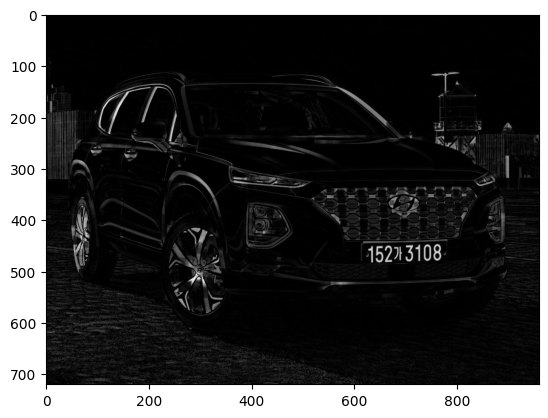

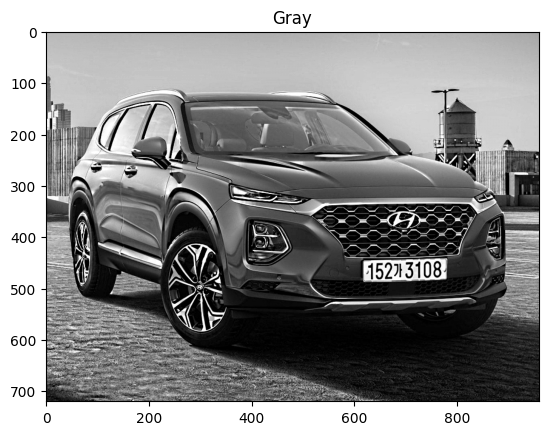

In [4]:
imgTopHat = cv2.morphologyEx(img_gray, cv2.MORPH_TOPHAT,structuringElement)

plt.imshow(imgTopHat, 'gray')
plt.show()
imgBlackHat = cv2.morphologyEx(img_gray, cv2.MORPH_BLACKHAT,structuringElement)

plt.imshow(imgBlackHat, 'gray')
plt.show()

imgGrayscalePlusTopHat =cv2.add(img_gray, imgTopHat)
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)
plt.imshow(gray, 'gray')
plt.title("Gray")
plt.show()

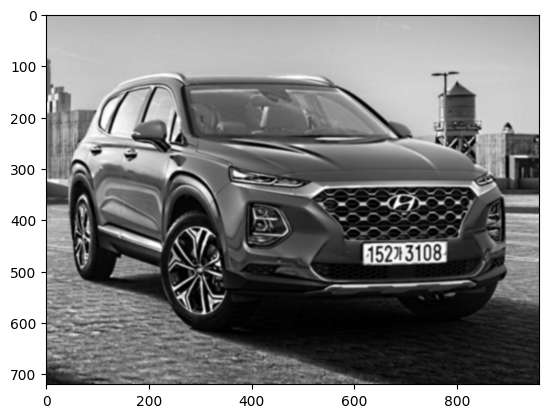

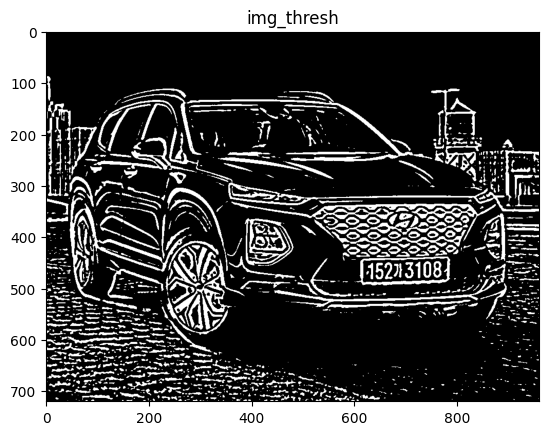

In [5]:
img_blurred = cv2.GaussianBlur(gray, ksize=(7,7), sigmaX=0)

plt.imshow(img_blurred, 'gray')
plt.show()

img_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19,
    C=9
)
plt.imshow(img_thresh, 'gray')
plt.title('img_thresh')
plt.show()

# 6. Car image preprocessing (bounding box lining)

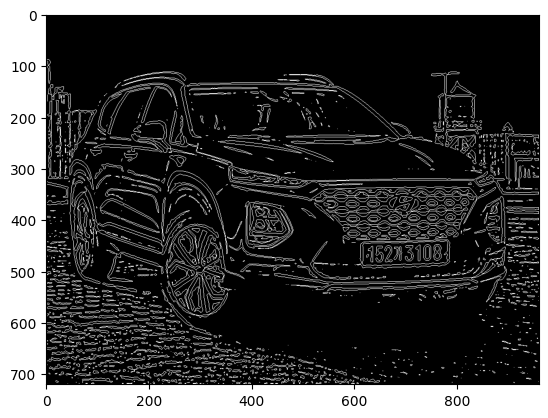

720 960 3


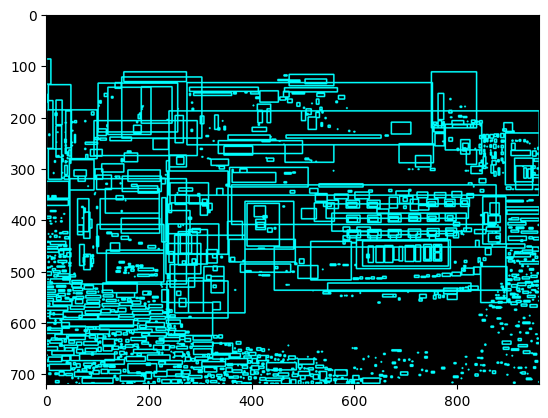

[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0 255 255]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]


In [6]:
contours, hierarchy = cv2.findContours(
    img_thresh,
    mode=cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)
temp_res = np.zeros((h, w, c), dtype=np.uint8)

cv2.drawContours(temp_res, contours=contours, contourIdx=-1 , color=(255,255,255))
plt.imshow(temp_res,'gray')
plt.show()


temp_res = np.zeros((h, w, c), dtype=np.uint8)
contours_dict = []

for contour in contours:
    x1, y1, w1, h1 = cv2.boundingRect(contour)
    # print(x, y, w, h)
    cv2.rectangle(temp_res, pt1=(x1,y1), pt2=(x1+w1,y1+h1), color=(0,255,255), thickness=2)

    #insert to dict
    contours_dict.append({
        'contour':contour,
        'x':x1,
        'y':y1,
        'w':w1,
        'h':h1,
        'cx':x1+(w1/2),
        'cy':y1+(h1/2)
    })
print(h, w, c)
plt.imshow(temp_res,'gray')
plt.show()
temp_res1 = np.copy(temp_res)
print(temp_res1)

Car image select candidates by char size transform

720 960 3


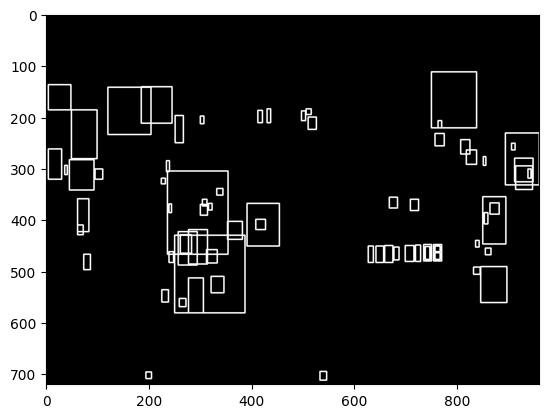

In [7]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2,8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

print (h, w, c)
cnt = 0
for d in contours_dict:
    area = d['w']*d['h']
    ratio = d['w']/d['h']

    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
#visualize

temp_res = np.zeros((h,w,c),dtype=np.uint8)

for d in possible_contours:
    cv2.rectangle(temp_res, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'],d['y']+d['h']), color=(255,255,255),thickness=2)

plt.imshow(temp_res, 'gray')
plt.show()

Car image select Candidates by Arrangement of Contours transform

In [8]:
MAX_DIAG_MULTIPLYER = 5
MAX_ANGLE_DIFF = 12.0
MAX_AREA_DIFF = 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3

In [9]:
def find_chars(contour_list):
    matched_result_idx = []

    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue
            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagnoal_len1 = np.sqrt(d1['w'] ** 2 + d1['h']**2)
            dist = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy/dx))
            area_diff = abs(d1['w']*d1['h'] - d2['w']*d2['h']) / (d1['w']*d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] -d2['h']) / d1['h']

            if dist<diagnoal_len1*MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff<MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)

        recursive_contour_list = find_chars(unmatched_contour)

        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break
    return matched_result_idx

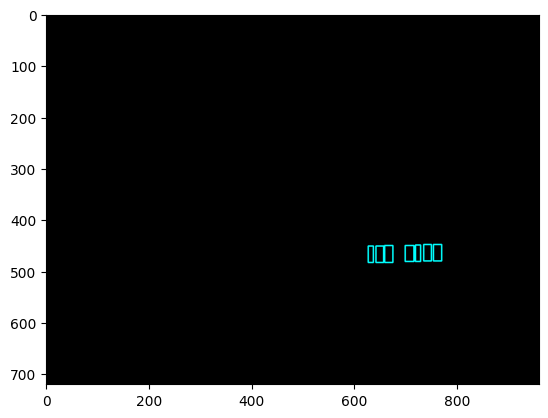

In [10]:
res_idx = find_chars(possible_contours)

matched_res = []

for idx_list in res_idx:
    matched_res.append(np.take(possible_contours, idx_list))

temp_res = np.zeros((h,w,c), dtype=np.uint8)

for r in matched_res:
    for d in r:
        cv2.rectangle(temp_res, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'],d['y']+d['h']), color=(0, 255, 255), thickness=2)

plt.imshow(temp_res, 'gray')
plt.show()

In [11]:
PLATE_WIDTH_PADDING = 1.3
PLATE_HEIGHT_PADDING = 1.5

MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for _, matched_chars in enumerate(matched_res):
    sorted_chars = sorted(matched_chars, key=lambda x:x['cx'])
    plate_cx=(sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) /2
    plate_cy=(sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) /2

    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING

    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height/ len(sorted_chars)*PLATE_HEIGHT_PADDING)

    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )

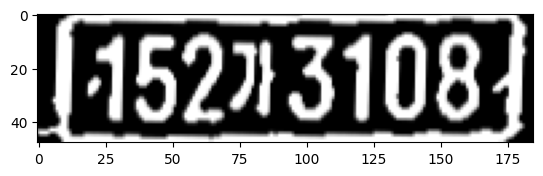

In [12]:
angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))

rotation_mat = cv2.getRotationMatrix2D(center=( plate_cx,plate_cy), angle=angle, scale=1.0)

img_rotated = cv2.warpAffine(img_thresh, M=rotation_mat, dsize=(w,h))

img_cropped = cv2.getRectSubPix(
    img_rotated,
    patchSize=(int(plate_width), int(plate_height)),
    center=(int(plate_cx), int(plate_cy))
)

plate_imgs.append(img_cropped)
plate_infos.append({
    'x' : int(plate_cx - plate_width /2),
    'y' : int(plate_cy - plate_height /2),
    'w' : int(plate_width),
    'h' : int(plate_height)
})

plt.imshow(img_cropped, 'gray')
plt.show()

Another Thresholding to find chars

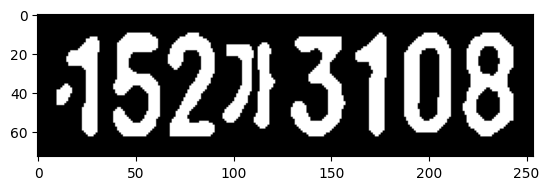

In [13]:
longest_idx, longest_text = -1,0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0,0), fx=1.6,fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type= cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    contours, hierarchy = cv2.findContours(plate_img, mode=cv2.RETR_LIST,method=cv2.CHAIN_APPROX_SIMPLE)

    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        c_x, c_y, c_w, c_h = cv2.boundingRect(contour)
        area_temp = c_w*c_h
        ratio = c_w / c_h

        if area_temp>MIN_AREA \
        and c_w>MIN_WIDTH and c_h>MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if c_x < plate_min_x:
                plate_min_x = c_x
            if c_y <plate_min_y:
                plate_min_y = c_y
            if c_x + c_w > plate_max_x:
                plate_max_x = c_x + c_w
            if c_y + c_h > plate_max_y:
                plate_max_y = c_y + c_h
    img_result = plate_img[plate_min_y : plate_max_y , plate_min_x : plate_max_x]
    img_result = cv2.GaussianBlur(img_result, ksize=(3,3), sigmaX=0)
    _, img_result= cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

    plt.imshow(img_result, 'gray')
    plt.show()
#

차량 번호판 바운딩 박스 표시 결과 이미지

In [18]:
info = plate_infos[longest_idx]
img_out = img.copy()

print(info)
cv2.rectangle(img_out, (info['x'], info['y']),(info['x']+info['w'], info['y']+info['h']),color=(0,255,255),thickness=2)

{'x': 604, 'y': 441, 'w': 185, 'h': 48}


array([[[181, 181, 189],
        [180, 180, 188],
        [181, 181, 189],
        ...,
        [154, 162, 181],
        [155, 163, 184],
        [156, 164, 185]],

       [[182, 182, 190],
        [181, 181, 189],
        [181, 181, 189],
        ...,
        [155, 163, 182],
        [154, 162, 183],
        [155, 163, 184]],

       [[182, 182, 190],
        [181, 181, 189],
        [181, 181, 189],
        ...,
        [157, 165, 186],
        [155, 163, 184],
        [155, 163, 184]],

       ...,

       [[ 23,  28,  48],
        [ 22,  27,  47],
        [ 23,  28,  48],
        ...,
        [ 13,  22,  39],
        [ 13,  21,  40],
        [ 16,  24,  43]],

       [[ 28,  33,  53],
        [ 27,  32,  52],
        [ 21,  26,  46],
        ...,
        [ 16,  25,  42],
        [ 19,  27,  46],
        [ 17,  25,  44]],

       [[ 26,  31,  51],
        [ 25,  30,  50],
        [ 23,  28,  48],
        ...,
        [ 14,  23,  40],
        [ 15,  23,  42],
        [ 12,  20,  39]]